___

# LLM configuration practice

___

#### LLM configuratino basic process

1. pretraining(사전 훈련)으로 일반적인 언어 능력을 가르친다

2. fine tuning(미세조정) 단계에서 특정 용도에 맞게 다듬는다   

    > 여기까지가 기본적인 절차   


3. 데이터베이스(혹은 인터넷) 검색 기능을 추가한다   

    > 지식의 범위와 정확성을 더 높일 수 있다   
    

4. 내부적으로 질의를 반복하여 더 좋은 결론을 도출한다   

    > 사람이 생각을 거듭하여 더 깊이 있는 결론을 이끌어내는 과정과 같다   


#### the stage of practice   

1. 훈련 데이터 준비

2. 데이터 로더 정의

3. 모델 정의

4. 훈련

5. 결과 확인

___

#### computer

* macbook pro m4 pro

#### packages

* miniconda=24.11.1

* python=3.9.20
    ```sh
    conda create -n LLM python=3.9.20
    ```

* tiktoken=0.9.0
    ```sh
    pip install tiktoken
    ```

* torch=2.6.0
    ```sh
    pip3 install torch torchvision torchaudio
    ```

___

___

## 1. 훈련 데이터 준비

* [해리포터 영어 원서](https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books?select=02+Harry+Potter+and+the+Chamber+of+Secrets.txt)
    ```sh
    curl -o LLM_configuration/data/file-name.txt "download link"
    ```

In [1]:
import re

def clean_text(filename, path):
    with open(path + '/' + filename,  'r', encoding='utf-8') as file:
        book_text = file.read()
        
    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄 바꿈을 공백으로
    cleaned_text = re.sub(r's+', ' ', cleaned_text) # 연속되는 공백을 하나의 공백으로
    
    print('cleaned_' + filename, len(cleaned_text), 'characters') # 글자 수 출력
    
    with open(path + '/' + 'cleaned_' + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text) # 잘 정리된 훈련 데이터 저장

In [2]:
filename_list = ['01_Harry_Potter_and_the_Sorcerers_Stone.txt',
                 '02_Harry_Potter_and_the_Chamber_of_Secrets.txt',
                 '03_Harry_Potter_and_the_Prisoner_of_Azkaban.txt',
                 '04_Harry_Potter_and_the_Goblet_of_Fire.txt',
                 '05_Harry_Potter_and_the_Order_of_the_Phoenix.txt',
                 '06_Harry_Potter_and_the_Half-Blood_Prince.txt',
                 '07_Harry_Potter_and_the_Deathly_Hallows.txt']
file_path = '/Users/kh22cho/LLM_configuration/data'

for filename in filename_list:
    clean_text(filename, file_path)

cleaned_01_Harry_Potter_and_the_Sorcerers_Stone.txt 435335 characters
cleaned_02_Harry_Potter_and_the_Chamber_of_Secrets.txt 487913 characters
cleaned_03_Harry_Potter_and_the_Prisoner_of_Azkaban.txt 619717 characters
cleaned_04_Harry_Potter_and_the_Goblet_of_Fire.txt 1091860 characters
cleaned_05_Harry_Potter_and_the_Order_of_the_Phoenix.txt 1486941 characters
cleaned_06_Harry_Potter_and_the_Half-Blood_Prince.txt 980175 characters
cleaned_07_Harry_Potter_and_the_Deathly_Hallows.txt 1131296 characters


#### 토큰화 진행

UTF-8 BPE (Bype Pair Encoding)

문자열 데이터를 숫자로 변환하는 과정

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2') # gpt2에서 사용하는 tokenizer

#### 토큰화의 간단한 예시

```python
text = 'Harry Potter was a wizard.' # token으로 바꿀 예시 문장 | neural net이 이해할 수 있게 적당히 자른 것이 token

tokens = tokenizer.encode(text) # text를 숫자로 바꾸는 과정 

print('글자수 :', len(text), '토큰수 :', len(tokens))
print(tokens) # 6개의 token들로 text를 변환함 | .도 문장의 끝이라는 의미의 token
print(tokenizer.decode(tokens)) # 6개의 token들을 다시 decode하여 text로 원상 복구
for t in tokens:
    print(f'{t} >>> {tokenizer.decode([t])}')
```
```
글자수 : 26 토큰수 : 6   
[18308, 14179, 373, 257, 18731, 13]   
Harry Potter was a wizard.   
18308 >>> Harry   
14179 >>>  Potter   
373 >>>  was   
257 >>>  a   
18731 >>>  wizard   
13 >>> .
```

#### 한글과 한자가 섞여있는 문장에 대한 tokenizer 예제

```python
from transformers import AutoTokenizer # pip install transformers

tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용 | 가장 잘되었던 모델
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

print("Vocab size :", len(tokenizer))

text = "대사께서는 도(道)를 얻은 모양이구려."

tokens = tokenizer.encode(text)

print(len(text), len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
```

#### 글자 단위로 토큰화하는 예시 | 비효율적이므로 잘 사용하지 않음

```python
for char in text:
    token_ids = tokenizer.encode(char) # 한 글자씩 인코딩(토큰화)
    decoded = tokenizer.decode(token_ids) # 한 글자씩 디코딩
    print(f"{char} >>> {token_ids} >>> {decoded}") # 한 글자 단위이므로 공백도 토큰이 됨
```
```
H >>> [39] >>> H
a >>> [64] >>> a
r >>> [81] >>> r
r >>> [81] >>> r
y >>> [88] >>> y
  >>> [220] >>>  
P >>> [47] >>> P
o >>> [78] >>> o
t >>> [83] >>> t
t >>> [83] >>> t
e >>> [68] >>> e
r >>> [81] >>> r
  >>> [220] >>>  
w >>> [86] >>> w
a >>> [64] >>> a
s >>> [82] >>> s
  >>> [220] >>>  
a >>> [64] >>> a
  >>> [220] >>>  
w >>> [86] >>> w
i >>> [72] >>> i
z >>> [89] >>> z
a >>> [64] >>> a
r >>> [81] >>> r
d >>> [67] >>> d
. >>> [13] >>> .
```

___

___

## 2. 데이터 로더 (DataLoader)

입력 데이터가 많아질수록 neural net도 무시무시하게 커지기 때문에

전체 데이터를 한번에 사용하지 않고, 몇개씩 쪼개주는 기능을 하는 것이 ```Dataset```

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length = 32, stride = 4):
        self.input_ids = []
        self.target_ids = []
        
        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt) # 책 한권을 token으로 바꿈
        
        print('# of tokens in txt :', len(token_ids)) # token이 몇개정도 되는지
        
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1] # 앞의 몇개의 단어(input)가 오면, 그 다음으로 오는 단어(target)를 의미
            self.input_ids.append(torch.tensor(input_chunk)) # input를 넣으면, 
            self.target_ids.append(torch.tensor(target_chunk)) # target하고 가급적 똑같은 대답을 하도록 훈련을 시킴
            # example
            # Text :   Harry Potter was a Wizard.
            # input :  Harry Poter
            # target :              was
            
    def __len__(self): # 훈련을 시킬 수 있는 조각이 전부 몇개인지 알려주는 함수
        return len(self.input_ids)
    
    def __getitem__(self, idx): # DataLoader를 사용할때 실제로 호출하는 함수
        return self.input_ids[idx], self.target_ids[idx] # input의 id와 target의 id를 쌍으로 반환

#### Harry Potter 모든 책을 합쳐서 이용할 시

```python
txt = "" # 여러 책의 내용을 합칠 문자열
for f in filename_list:
    with open(file_path + '/' + 'cleaned_' + f, 'r', encoding='utf-8-sig') as file: # 선택 : -sig를 붙여서 BOM 제거
        print('open', f)
        txt += file.read() # 책을 읽어온다

# gpu 사용이 어려울 때, txt의 일부만 이용하여 cpu에 부담을 줄이고 싶을때
# txt = txt[:100000]
```

```
open 01_Harry_Potter_and_the_Sorcerers_Stone.txt
open 02_Harry_Potter_and_the_Chamber_of_Secrets.txt
open 03_Harry_Potter_and_the_Prisoner_of_Azkaban.txt
open 04_Harry_Potter_and_the_Goblet_of_Fire.txt
open 05_Harry_Potter_and_the_Order_of_the_Phoenix.txt
open 06_Harry_Potter_and_the_Half-Blood_Prince.txt
open 07_Harry_Potter_and_the_Deathly_Hallows.txt
# of tokens in txt : 1912071
```

mps는 너무 오래걸려서 책 한권만 이용하기로 결정

In [5]:
# with open('cleaned_한글문서.txt', 'r', encoding='utf-8-sig') as file: # 선택 : -sig를 붙여서 BOM 제거
with open(file_path + '/' + 'cleaned_01_Harry_Potter_and_the_Sorcerers_Stone.txt', 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

dataset = MyDataset(txt, max_length = 32, stride = 4) # dataset을 정의

train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True) # dataset을 이용하여 pytorch의 DataLoader를 만든다

# 주의 : 여기서는 코드를 단순화하기 위해 test, valid는 생략하고 train_loader만 만들었습니다
#       관련된 ML 이론은 train vs test vs validation 등으로 검색하여 참고

# of tokens in txt : 138857


#### DataLoader가 내부적으로 어떻게 작동하는지
```python
dataiter = iter(train_loader) # loader를 iterator로 바꿔주고

x, y = next(dataiter) # next를 이용하여 실제 x, y로 받아온다 | x, y는 각각 input, target이며 token이다

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist())) # target이 하나 밀린 형태
```
```
an fer to Slytherin at once, becau e it wa  hi  de tiny. Harry told the turban he didn’t want to
 fer to Slytherin at once, becau e it wa  hi  de tiny. Harry told the turban he didn’t want to be
```

```python
print(x[0])
print(y[0]) # target이 하나 밀린 형태 | token으로 보면 더 명확함
```
```
tensor([  272, 11354,   284, 31615,   490,   259,   379,  1752,    11,   639,
          559,   304,   340,  2082,   220, 23105,   220,   390,  7009,    13,
         5850,  1297,   262,  7858,  3820,   339,  1422,   447,   247,    83,
          765,   284])
tensor([11354,   284, 31615,   490,   259,   379,  1752,    11,   639,   559,
          304,   340,  2082,   220, 23105,   220,   390,  7009,    13,  5850,
         1297,   262,  7858,  3820,   339,  1422,   447,   247,    83,   765,
          284,   307])
```

___

___

## 3. 모델 정의

뉴럴 네트워크 모델 정의

모델은 교재([Build a Large Language Model (From Scratch)](https://github.com/rasbt/LLMs-from-scratch))에서 제공하는 예제 코드를 약간 수정한 정도

In [6]:
# model's parameter

# 50257 Tiktoken | 사전에 단어가 몇개나 있는지
VOCAB_SIZE = tokenizer.n_vocab
# VOCAB_SIZE = len(tokenizer) # AutoTokenizer일 경우

CONTEXT_LENGTH = 128 # Shortened context length (orig : 1024)
EMB_DIM = 768 # Embedding dimention
NUM_HEADS = 12 # Number of attention heads
NUM_LAYERS = 8 # Number of layers
DROP_RATE = 0.1 # Dropout rate
QKV_BIAS = False # Query-key-value bias

In [7]:
import torch.nn as nn

class MultiHeadAttention(nn.Module): # self attention의 핵심이 되는 부분
    def __init__(self, d_in, d_out):
        super().__init__()
        
        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module): # neural net 가중치 값들이 너무 들쑥날쑥하지 않고 적당한 범위 내에 몰려있도록 만들어줌
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module): # Linear, GELU activation 다음에 다시 Linear가 있는 간단한 구조
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module): # MultiHeadAttention, FeedForward, LayerNorm등이 사용됨
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)
    
        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module): # GPT model을 사용
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)]) # TransformerBlock이 정의된 부분으로 이동하면,

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

#### Transformer architecture

Transformer 구조 중에서 Masked Multi-Head Attention이라는 것은 훈련시키는 기본 원리와 밀접한 관련이 있음

<img src="figure/Transformer_architecture.png" width="30%">

화살표 왼쪽 그림의 행렬을 보면, 단어끼리 얼마나 관계가 깊은지에 대한 값을 저장한 행렬

이번에는 화살표 오른쪽 그림의 오른쪽 윗부분을 보면, 숨겨져있는 부분이 있는데 이것이 Masked Multi-Head Attention

데이터 셋을 만들때 다음 단어를 추측하는 것과 연관이 되어있음

앞부분과 뒷부분을 같이 주면, 다음단어라는 정답을 주는 꼴이 되어버리므로 숨겨서 학습

즉, 미래에 오는 단어를 모르게 학습을 하도록 네트워크 구조를 만든 것

<img src="figure/Masked_Multi_Head_Attention.webp" width="60%">

#### GELU activation function

<img src="./figure/GELU.png" width="40%" height="30%"></img><br/>

___

___

## 4. 훈련

nvidia GPU가 아닌 silicon mac의 GPU를 사용하려면 조금 다르게 셋팅이 필요

apple에서는 GPU 대신 MPS(Metal Performance Shaders)라고 함

MPS는 기존의 CUDA 또는 OpenCL과 같은 라이브러리와 달리 애플에서 직접 제공하는 프레임 워크, 따라서 애플 GPU 기술에 최적화되어 있음

- [How to use GPU Acceleration in silicon mac (MPS setting)](https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c/)

In [8]:
# PyTorch에서 MPS가 활성화되어 있는지 확인하는 방법
import torch

# 현재 환경에서 MPS를 사용할 수 있는지 여부
print('GPU available in current env :', torch.backends.mps.is_available())

# 현재 PyTorch 설치가 MPS 활성화로 빌드되었는지 여부 
# True : 현재 설치된 PyTorch가 MPS 활성화로 빌드 되었음
print('PyTorch is built with MPS activation :', torch.backends.mps.is_built())

# MPS를 사용하기 위한 디바이스를 설정
device = torch.device('mps')
print("Current device :", device)

torch.manual_seed(0)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

GPU available in current env : True
PyTorch is built with MPS activation : True
Current device : mps


In [9]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(30):
    model.train() # Set model to training mode
    
    epoch_loss = 0
    
    # input하고 target을 받아 neural net에 넣음 
    # 이때 input과 target을 하나씩이 아닌 묶음, batch로 넣음
    # 만약 gpu 메모리가 적은 경우, train_loader 초기화 과정에서 batch size를 낮추면 됨
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        
        # train_loader로부터 input, target batch를 받아 device로 복사
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        
        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # 대답을 얼마나 잘했는지 평가
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients | 대답을 더 잘하도록 가중치 업데이트
        tokens_seen += input_batch.numel()
        global_step += 1
        
        if global_step %1000 == 0:
            print(f'Tokens seen : {tokens_seen}')
        # Optional evaluation step
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch : {epoch + 1}, Loss : {avg_loss}')
    # 에포크가 끝난 후 메모리 사용량 출력
    print(f"Allocated GPU Memory: {torch.mps.current_allocated_memory() / (1024 ** 3):.2f} GB")
    torch.save(model.state_dict(), 'model_' + str(epoch + 1).zfill(3) + '.pth') 
    
# 주의 : 여기서는 편의상 모든 데이터를 train에 사용
#       ML에서는 일부 데이터를 validation에 사용하는 것이 일반적       

Tokens seen : 1024
Tokens seen : 1025024
Epoch : 1, Loss : 3.3148016626104657
Allocated GPU Memory: 2.37 GB
Tokens seen : 2049024
Epoch : 2, Loss : 1.244698075735701
Allocated GPU Memory: 2.37 GB
Tokens seen : 3073024
Epoch : 3, Loss : 0.5141318499822018
Allocated GPU Memory: 2.37 GB
Tokens seen : 4097024
Epoch : 4, Loss : 0.3889944906109373
Allocated GPU Memory: 2.37 GB
Tokens seen : 5121024


KeyboardInterrupt: 

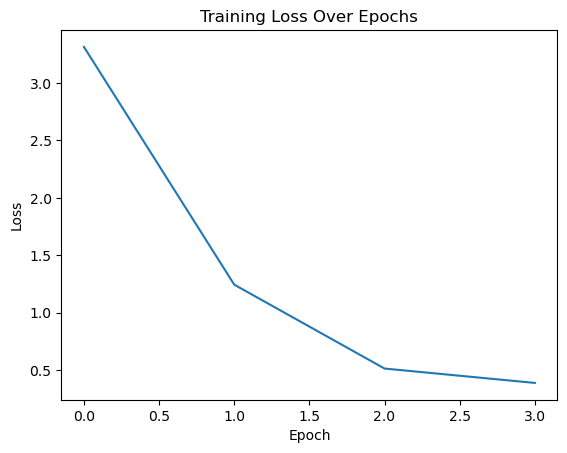

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# 보충: validation loss를 같이 그려서 비교하는 사례 https://www.geeksforgeeks.org/training-and-validation-loss-in-deep-learning/

#### 보충 코드

- [validation loss를 같이 그려서 비교하는 사례](https://www.geeksforgeeks.org/training-and-validation-loss-in-deep-learning/)

____

____

## 5. 결과 확인

In [12]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load('model_004.pth', map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [13]:
idx = tokenizer.encode('Dobby is') # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f'{p:.2f}\t {tokenizer.decode([i])}')
    
# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

9.63	  me
9.61	  
8.71	  I
8.46	  about
8.03	  if
7.56	  not
7.35	  an
7.18	  a
6.72	  people
6.50	  it
 me
